# Evaluating & Checking Process for finding an optimal fraction of the best featurs for training the Binary ML model.

In [7]:
import pandas as pd
import numpy as np
import time
import copy
import itertools
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
print("✅ All required libraries successfully imported.")


✅ All required libraries successfully imported.


In [3]:
# THIS PART CHANGES WITH DIFFERENT DATASETS:
datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'libras_move': "/content/movement_libras.data", # dataset is on the local machine. (downloaded and unzipped from https://archive.ics.uci.edu/static/public/181/libras+movement.zip)
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
}

data_dict = {}
for name, url in datasets.items():
    data = pd.read_csv(url, header=None)

    if name == 'us_crime':
        data = data.drop(columns=[3])
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(float).apply(lambda x: 1 if x > 0.65 else 0).astype(int)  # Target is the last column
        print(f'dataset {name}: Target: > 0.65 (1) or < 0.65 (0).')
    elif name == 'libras_move':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].apply(lambda x: 1 if x == 1 else 0).astype(int)  # Target is the last column
        print(f'dataset {name}: Target: 1 or others (0).')
    elif name == 'letter_img':
        X = data.iloc[1:, 1:]  # Features start from the second column
        y = data.iloc[1:, 0].apply(lambda x: 1 if x == 'Z' else 0).astype(int)  # Target is the first column
        print(f'dataset {name}: Target: "Z" or others (0).')
    elif name == 'mammography':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(int)  # Target is the last column
        print(f'dataset {name}: Target: 1 (1= Malignant) or 0 (0= Benign).')

    data_dict[name] = (X, y)


dataset us_crime: Target: > 0.65 (1) or < 0.65 (0).
dataset libras_move: Target: 1 or others (0).
dataset letter_img: Target: "Z" or others (0).
dataset mammography: Target: 1 (1= Malignant) or 0 (0= Benign).


In [5]:
def calculate_f1_scores_multiple_splits(X_scaled, y, num_splits= 5): # POINT: MORE num_splits FOR MORE ACCURATE RESULTS (real features ranking).
    start_time = time.time()  # Record start time
    # multiple splits (tests) for having a more reliable and accurate evaluating features because of the random state problem.
    f1_scores = []
    for _ in range(num_splits):
      random_state = np.random.randint(100) # Generate a random seed
      for i in range(X_scaled.shape[1]):
          X_feature = X_scaled.iloc[:, i].values.reshape(-1, 1)

          # Convert '?' to NaN and then impute missing values
          X_feature = np.where(X_feature == '?', np.nan, X_feature)
          imputer = SimpleImputer(strategy='median') # Or another suitable strategy
          X_feature = imputer.fit_transform(X_feature)

          X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.25, random_state= random_state)
          # random_state for having the mix of examples.


          clf = DecisionTreeClassifier()
          clf.fit(X_train, y_train)
          y_pred = clf.predict(X_test)

          average = 'binary'
          f1 = f1_score(y_test, y_pred, average= average)
          f1_scores.append(f1)

    end_time = time.time()  # Record end time
    execution_time = end_time - start_time  # Calculate execution time

    return np.array(f1_scores).reshape(num_splits, -1), execution_time/ num_splits # Reshape for easy averaging and returning time


In [6]:
# FEEL FREE TO EXPERIMENT WITH DIFFERENT ML ALGORITHMS HERE.
def evaluate_svm_with_selected_features_multiple_splits(X_scaled, y, feature_ranking, fractions, num_splits= 5, scaler=None): # POINT: MORE num_splits FOR MORE ACCURATE RESULTS (real outcomes of fractions).
    results_all= []
    for _ in range(num_splits):
      random_state= np.random.randint(100)
      results = {'fraction': [], 'f1_score': [], 'precision': [], 'recall': []}
      for fraction in fractions:
          num_features = max(1, int(fraction * X_scaled.shape[1])) # ensure that at least one feature is selected.
          selected_features = feature_ranking[:num_features]
          X_selected = X_scaled.iloc[:, selected_features]

          # Convert '?' to NaN and then impute missing values
          X_selected = np.where(X_selected == '?', np.nan, X_selected)
          imputer = SimpleImputer(strategy='median') # median is better than mean (maybe because of the outlier data in datasets.)
          X_selected = imputer.fit_transform(X_selected)

          X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state= random_state)

          X_train = scaler.fit_transform(X_train)
          X_test = scaler.transform(X_test)

          svm = SVC(kernel='rbf', class_weight= 'balanced')
          svm.fit(X_train, y_train)
          y_pred = svm.predict(X_test)

          average = 'binary'
          f1 = f1_score(y_test, y_pred, average= average)
          precision = precision_score(y_test, y_pred, average= average)
          recall = recall_score(y_test, y_pred, average= average)

          results['fraction'].append(fraction)
          results['f1_score'].append(f1)
          results['precision'].append(precision)
          results['recall'].append(recall)
      results_all.append(results)
    return results_all


Evaluating dataset: us_crime
  X shape: (1994, 126)
  y shape: (1994,)
  Majority-Minority Class Ratio: 12:1
Feature evaluation for us_crime, took 0.79 seconds.
Average time per feature: 0.0063 seconds.


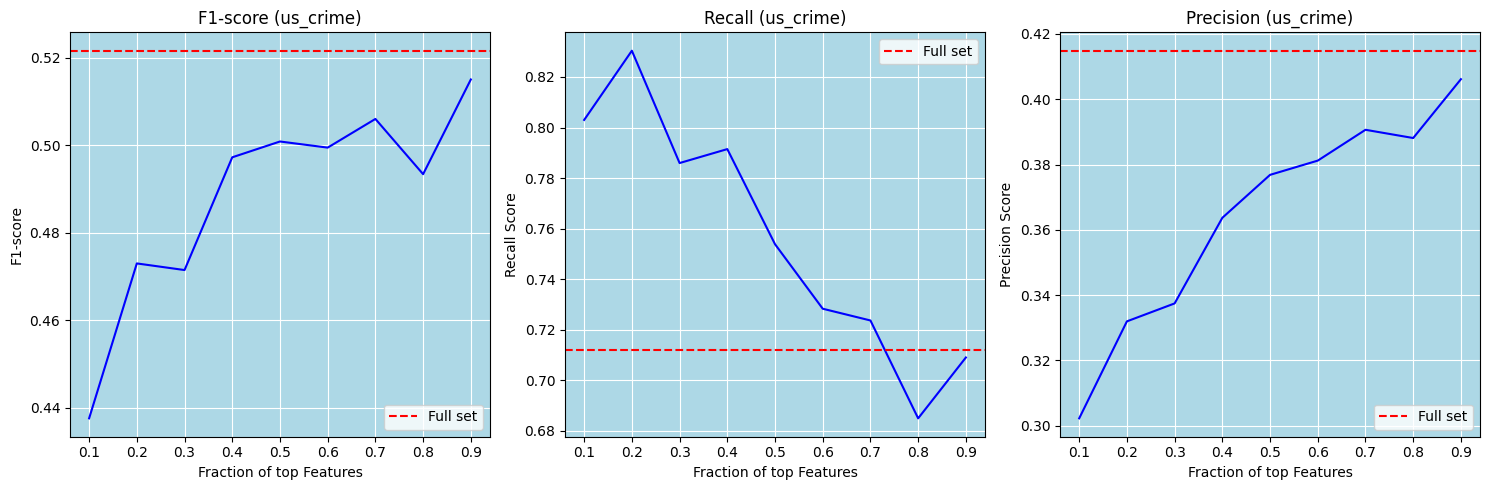

The best fraction of top features in this problem based on the F1-score is 1.0 with F1-score of 0.521666.
Therefore we can use the 1.0 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: PctKids2Par:49, F1-score based Rank: 1, F1-score: 0.414020
Feature: PctTeen2Par:51, F1-score based Rank: 2, F1-score: 0.349977
Feature: PctFam2Par:48, F1-score based Rank: 3, F1-score: 0.336710
Feature: PctIlleg:55, F1-score based Rank: 4, F1-score: 0.328525
Feature: PctYoungKids2Par:50, F1-score based Rank: 5, F1-score: 0.315482
Feature: racePctWhite:8, F1-score based Rank: 6, F1-score: 0.308710
Feature: PctPolicBlack:111, F1-score based Rank: 7, F1-score: 0.297831
Feature: PctPolicWhite:110, F1-score based Rank: 8, F1-score: 0.283876
Feature: racepctblack:7, F1-score based Rank: 9, F1-score: 0.280942
Feature: NumIlleg:54, F1-score based Rank: 10, F1-score: 0.264309
Feature: FemalePctDiv:45, F1-score based Rank: 11, F1-score: 0.226699
Feature: 

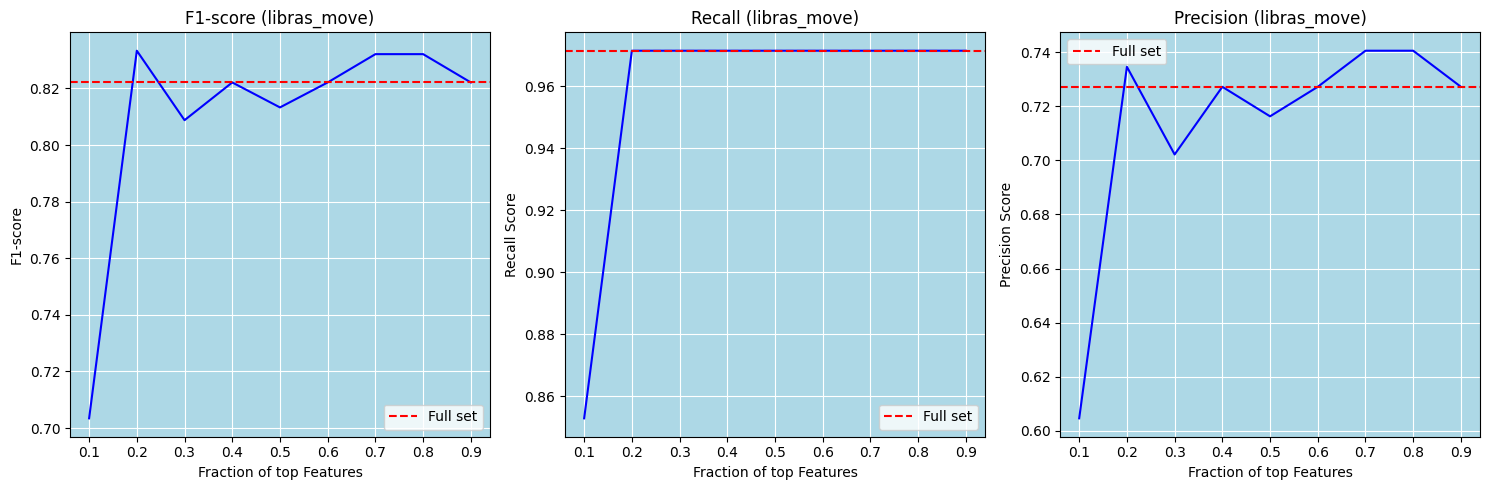

The best fraction of top features in this problem based on the F1-score is 0.2 with F1-score of 0.833333.
Therefore we can use the 0.2 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: 28:28, F1-score based Rank: 1, F1-score: 0.445714
Feature: 50:50, F1-score based Rank: 2, F1-score: 0.340317
Feature: 54:54, F1-score based Rank: 3, F1-score: 0.335556
Feature: 31:31, F1-score based Rank: 4, F1-score: 0.281818
Feature: 48:48, F1-score based Rank: 5, F1-score: 0.271235
Feature: 75:75, F1-score based Rank: 6, F1-score: 0.259697
Feature: 71:71, F1-score based Rank: 7, F1-score: 0.254949
Feature: 38:38, F1-score based Rank: 8, F1-score: 0.220769
Feature: 24:24, F1-score based Rank: 9, F1-score: 0.217143
Feature: 14:14, F1-score based Rank: 10, F1-score: 0.186453
Feature: 49:49, F1-score based Rank: 11, F1-score: 0.169697
Feature: 11:11, F1-score based Rank: 12, F1-score: 0.163810
Feature: 32:32, F1-score based Rank: 13, F1-score: 0.

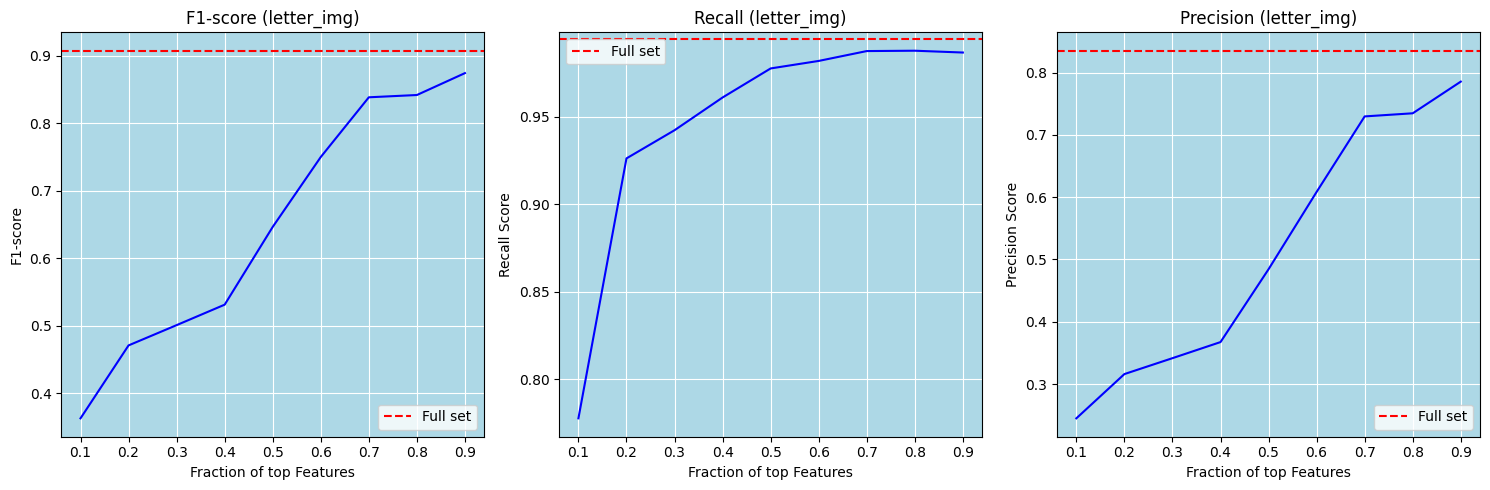

The best fraction of top features in this problem based on the F1-score is 1.0 with F1-score of 0.907630.
Therefore we can use the 1.0 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: y2bar:9, F1-score based Rank: 1, F1-score: 0.317284
Feature: high:4, F1-score based Rank: 2, F1-score: 0.018706
Feature: y-ege:15, F1-score based Rank: 3, F1-score: 0.002094
Feature: yegvx:16, F1-score based Rank: 4, F1-score: 0.000000
Feature: xegvy:14, F1-score based Rank: 5, F1-score: 0.000000
Feature: x-ege:13, F1-score based Rank: 6, F1-score: 0.000000
Feature: xy2br:12, F1-score based Rank: 7, F1-score: 0.000000
Feature: x2ybr:11, F1-score based Rank: 8, F1-score: 0.000000
Feature: xybar:10, F1-score based Rank: 9, F1-score: 0.000000
Feature: x2bar:8, F1-score based Rank: 10, F1-score: 0.000000
Feature: y-bar:7, F1-score based Rank: 11, F1-score: 0.000000
Feature: x-bar:6, F1-score based Rank: 12, F1-score: 0.000000
Feature: onpix:5, F1-sc

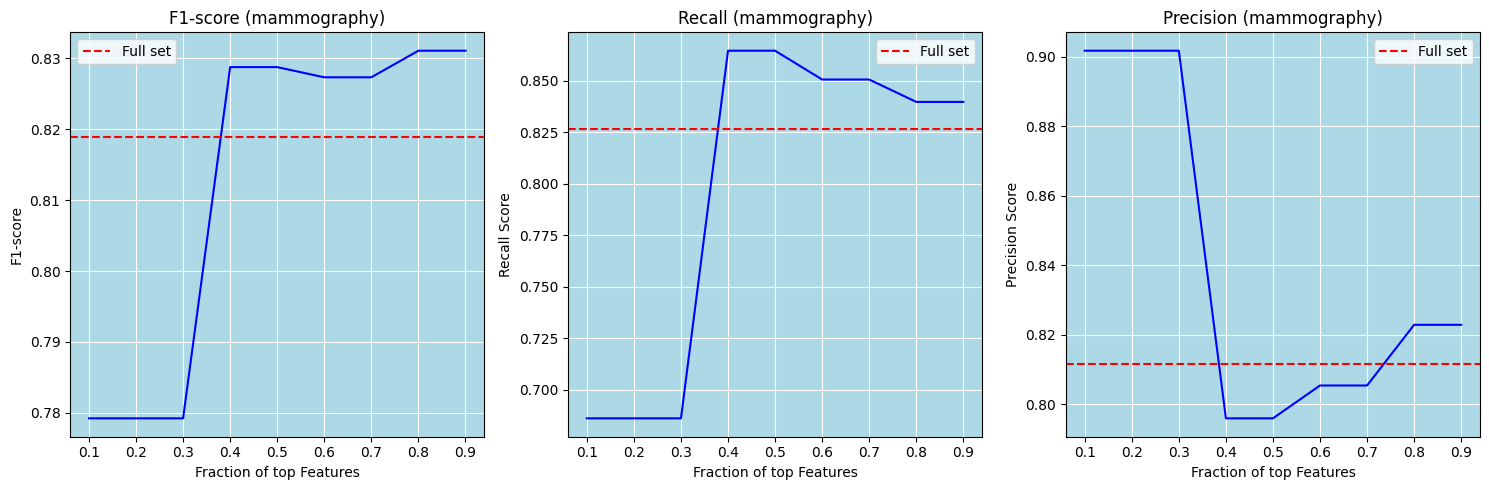

The best fraction of top features in this problem based on the F1-score is 0.8 with F1-score of 0.831096.
Therefore we can use the 0.8 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: BI-RADS:0, F1-score based Rank: 1, F1-score: 0.792946
Feature: Shape:2, F1-score based Rank: 2, F1-score: 0.761191
Feature: Margin:3, F1-score based Rank: 3, F1-score: 0.734628
Feature: Age:1, F1-score based Rank: 4, F1-score: 0.594646
Saved dataset with optimal feature set for mammography to mammography_optimal.csv
************************************************** 



In [6]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # POINT: MORE FRACTIONS FOR MORE ACCURATE RESULTS (real number of features).
# these three following lists are for the last summary metric section.
optimal_fractions= []
optimal_f1_scores= []
full_set_f1_scores= []
_010_f1_scores= [] # F1-scores of 0.1 fraction of top features for all datasets. # OPTIONAL

# these are for implementing the new ideas:
num_optimal_features_all_datasets= []
feature_ranking_all_datasets= []
scalers= {}

for name, (X, y) in data_dict.items():
    print(f"Evaluating dataset: {name}")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    unique, counts = np.unique(y, return_counts=True)
    ratio = int(counts[np.argmax(counts)] / counts[np.argmin(counts)])
    print(f"  Majority-Minority Class Ratio: {ratio}:1")
    # print("\n")

    # Imputing before scaling:
    # Convert '?' to NaN and then impute missing values
    X_imputed = np.where(X == '?', np.nan, X)
    imputer = SimpleImputer(strategy='median') # Or another suitable strategy
    X_imputed = imputer.fit_transform(X_imputed)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  # Convert back to DataFrame

    # Scale features for every dataset:
    # ensures that features are scaled only once per dataset, before feature selection.
    scaler = StandardScaler()
    scalers[name]= scaler

    X_scaled = scaler.fit_transform(X_imputed)
    X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns)  # Convert back to DataFrame

    f1_scores_multiple, eval_duration = calculate_f1_scores_multiple_splits(X_scaled, y)

    features_f1_scores= f1_scores_multiple.mean(axis=0) # Average across rows (splits)
    print(f"Feature evaluation for {name}, took {eval_duration:.2f} seconds.")  # Display all features evaluation execution time.
    print(f"Average time per feature: {eval_duration/ X_scaled.shape[1]:.4f} seconds.")  # Display average feature time.

    feature_ranking = np.argsort(features_f1_scores)[::-1] # Rank features based on their F1-scores and contains indices of the features sorted by their F1-scores from highest to lowest.

    # Evaluate SVM classifier with selected features
    results_multiple = evaluate_svm_with_selected_features_multiple_splits(X_scaled, y, feature_ranking, fractions, scaler=scaler)

    # Calculate average scores for each fraction:
    average_f1_scores = []
    average_precision_scores = []
    average_recall_scores = []

    for fraction in fractions:
        f1_scores_for_fraction = [result['f1_score'][fractions.index(fraction)] for result in results_multiple]
        precision_scores_for_fraction = [result['precision'][fractions.index(fraction)] for result in results_multiple]
        recall_scores_for_fraction = [result['recall'][fractions.index(fraction)] for result in results_multiple]

        average_f1_scores.append(np.mean(f1_scores_for_fraction))
        average_precision_scores.append(np.mean(precision_scores_for_fraction))
        average_recall_scores.append(np.mean(recall_scores_for_fraction))

    # Now we have average scores for each fraction across multiple splits
    # We use these average scores for plotting instead of the single-split scores
    f1_scores = copy.deepcopy(average_f1_scores)
    recall_scores = copy.deepcopy(average_recall_scores)
    precision_scores = copy.deepcopy(average_precision_scores)

    # Plotting:
    plt.figure(figsize=(15, 5))

    # Plot F1-score:
    plt.subplot(1, 3, 1)
    plt.plot(fractions[: -1], f1_scores[: -1], color= "blue")
    plt.axhline(y= f1_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'F1-score ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('F1-score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Recall score
    plt.subplot(1, 3, 2)
    plt.plot(fractions[: -1], recall_scores[: -1], color= "blue")
    plt.axhline(y= recall_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Recall ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('Recall Score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Precision score
    plt.subplot(1, 3, 3)
    plt.plot(fractions[: -1], precision_scores[: -1], color= "blue")
    plt.axhline(y= precision_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Precision ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('Precision Score')
    plt.grid(True, color='white')  # White grid lines
    plt.gca().set_facecolor('lightblue')  # Light blue background
    plt.grid(True)

    plt.tight_layout()
    plt.legend()
    plt.show()

    optimal_f1_score= max(f1_scores) # related to the optimal fraciton of all fractions.
    optimal_fraction= fractions[f1_scores.index(optimal_f1_score)] # The f1_scores list corresponds directly to the fractions list, with each score representing the F1-score for the respective fraction of top features.
    # TIP: The index() method prioritizes lower indices, so if a value appears multiple times, the optimal fraction will be determined by the earliest occurrence.
    print(f"The best fraction of top features in this problem based on the F1-score is {optimal_fraction} with F1-score of {optimal_f1_score:.6f}.")
    print(f"Therefore we can use the {optimal_fraction} fraction of top features as an optima.")

    # for summary metric section:
    optimal_fractions.append(optimal_fraction)
    optimal_f1_scores.append(optimal_f1_score)
    full_set_f1_scores.append(f1_scores[-1])
    _010_f1_scores.append(f1_scores[0]) # OPTIONAL

    num_optimal_features = int(optimal_fraction * X_scaled.shape[1])
    num_optimal_features_all_datasets.append(num_optimal_features)
    feature_ranking_all_datasets.append(feature_ranking)

    optimal_feature_indices = feature_ranking[:num_optimal_features] # of optimal fraction.
    print(f"Features (from highest to lowest score) as an optimal subset:")

    ######## # THIS PART CHANGES WITH DIFFERENT DATASETS:
    # having the names of features (again)!
    datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'libras_move': "/content/movement_libras.data", # dataset is on the local machine. (downloaded and unzipped from https://archive.ics.uci.edu/static/public/181/libras+movement.zip)
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
    }
    data_reimport = pd.read_csv(datasets[name], header=0)
    if name == 'us_crime':
        data_reimport = data_reimport.drop(columns=['communityname']) #dropping string value feature
        X_reimport = data_reimport.iloc[1:, :-1] # 1: confident starting row.
    elif name == 'libras_move':
        data_reimport = pd.read_csv(datasets[name], header= None) # No header in the dataset.
        X_reimport = data_reimport.iloc[1:, :-1]
    elif name == 'letter_img':
        X_reimport = data_reimport.iloc[1:, 1:]  # Features start from the second column
    elif name == 'mammography':
        X_reimport = data_reimport.iloc[1:, :-1]

    ########

    for index in optimal_feature_indices:
        feature_loc = X_scaled.columns[index]
        feature_name= X_reimport.columns[index]
        rank = np.where(feature_ranking == index)[0][0] + 1 # Calculate rank in the sorted feature_ranking list (1-based)
        f1_score_value = features_f1_scores[index]  # Get feature F1-score (f1_scores is 0-based)
        print(f"Feature: {feature_name}:{feature_loc}, F1-score based Rank: {rank}, F1-score: {f1_score_value:.6f}")

    # Saving the new csv file for future training and testing with features modified:
    X_optimal = X_reimport.iloc[:, optimal_feature_indices]
    # X_optimal = np.where(X_optimal == '?', np.nan, X_optimal)
    # imputer = SimpleImputer(strategy='median') # the same as what is done in the process.
    # X_optimal = imputer.fit_transform(X_optimal) # it should convert back to a Pandas DataFrame.
    y_new = y.rename("Target")  # Rename the target column from a numerical value.

    optimal_df = pd.concat([X_optimal, y_new], axis=1)  # Combine features and target
    optimal_df.to_csv(f"{name}_optimal.csv", index=False)  # Save to CSV
    print(f"Saved dataset with optimal feature set for {name} to {name}_optimal.csv")

    print(50* '*', '\n')


This shows us that we do not necessarily need to use all the features and also more than one induvidual feature lead to a good ML model.

## **Summary Metric:**

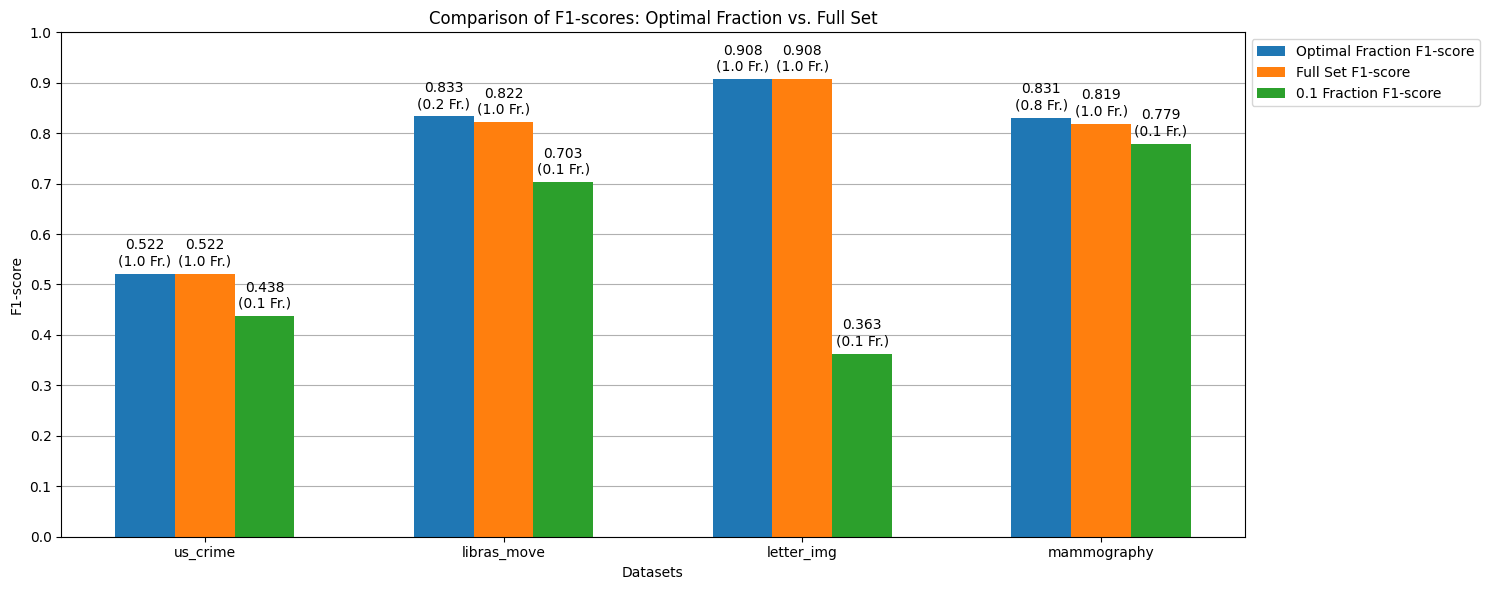

In [7]:
# Summary metrics of optimal fractions of top features vs. full set of features.

dataset_names = list(data_dict.keys())
bar_width = 0.20
index = np.arange(len(dataset_names))

plt.figure(figsize=(15, 6))
plt.bar(index, optimal_f1_scores, bar_width, label='Optimal Fraction F1-score', zorder= 2)
plt.bar(index + bar_width, full_set_f1_scores, bar_width, label='Full Set F1-score', zorder= 2)
plt.bar(index + 2* bar_width, _010_f1_scores, bar_width, label='0.1 Fraction F1-score', zorder= 2) # OPTIONAL

plt.xlabel('Datasets')
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores: Optimal Fraction vs. Full Set')
plt.xticks(index + (3* bar_width / 3), dataset_names) # RELATED TO THE OPTIONAL PART.
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
plt.tight_layout()
for i in index:
  plt.text(index[i], optimal_f1_scores[i] + 0.01, f"{optimal_f1_scores[i]:.3f}\n({optimal_fractions[i]} Fr.)", ha='center', va='bottom')
  plt.text(index[i] + bar_width, full_set_f1_scores[i] + 0.01, f"{full_set_f1_scores[i]:.3f}\n(1.0 Fr.)", ha='center', va='bottom')
  plt.text(index[i] + 2* bar_width, _010_f1_scores[i] + 0.01, f"{_010_f1_scores[i]:.3f}\n(0.1 Fr.)", ha='center', va='bottom') # OPTIONAL

plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks with a step of 0.1
plt.grid(True, axis= 'y', zorder= 0)
plt.show()


# **The second idea, considering the dependencies between features in pairs:**

In [ ]:
num_optimal_features_all_datasets[list(data_dict.keys()).index(name)]

3

In [ ]:
feature_ranking_all_datasets[list(data_dict.keys()).index('mammography')]

array([0, 2, 3, 1, 4])

In [ ]:
int(0.4 * X.shape[1])

2

In [ ]:
start_index

3

In [ ]:
end_index

5

In [ ]:
feature_ranking

array([0, 2, 3, 1, 4])

In [ ]:
additional_feature_indices

array([1, 4])

In [ ]:
pair_combinations

[(1, 4)]

In [ ]:
pair_f1_scores

{(1, 4): 0.6086956521739131}

In [ ]:
num_optimal_pairs

0

In [ ]:
optimal_pairs

[]

In [ ]:
optimal_feature_indices

array([0, 2, 3])

In [ ]:
all_optimal_features

[0, 2, 3]

In [ ]:
X_all_optimal

array([[ 0.36647709,  0.22038395,  1.43676223],
       [-0.19522065, -1.41505218, -1.18321596],
       [ 0.36647709,  1.03810202,  1.43676223],
       ...,
       [-0.19522065,  1.03810202,  1.43676223],
       [ 0.36647709,  1.03810202,  1.43676223],
       [-0.19522065,  0.22038395,  0.12677314]])

In [8]:
for name, (X, y) in data_dict.items():

    X_imputed = np.where(X == '?', np.nan, X)  # Convert '?' to NaN
    # Impute missing values in X:
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_imputed)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  # Convert to DataFrame

    # Scale the imputed data:
    X_scaled = scalers[name].fit_transform(X_imputed)
    X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns)

    # Select Optimal Pairs (example: top 40%)
    num_additional_features = int(0.4 * X_scaled.shape[1])
    start_index = num_optimal_features_all_datasets[list(data_dict.keys()).index(name)]
    end_index = start_index + num_additional_features

    feature_ranking = feature_ranking_all_datasets[list(data_dict.keys()).index(name)]
    additional_feature_indices = feature_ranking[start_index:end_index] # selecting pairs with choosing in the ranked features.

    pair_combinations = list(itertools.combinations(additional_feature_indices, 2)) # a list made of pair tuples.

    num_splits = 5  # Set the number of splits
    pairs_f1_scores_all_splits = []  # To store F1-scores for all splits
    for _ in range(num_splits):
        random_state = np.random.randint(100)
        pairs_f1_scores_single_split = {}  # To store F1-scores for a single split
        for pair in pair_combinations:
            feature1_index, feature2_index = pair
            X_pair = X_scaled.iloc[:, [feature1_index, feature2_index]]

            # Handle missing values (same as before)
            X_pair = np.where(X_pair == '?', np.nan, X_pair)
            imputer = SimpleImputer(strategy='median')
            X_pair = imputer.fit_transform(X_pair)

            X_train_pair, X_test_pair, y_train, y_test = train_test_split(X_pair, y, test_size=0.25, random_state=random_state)

            tree = DecisionTreeClassifier()
            tree.fit(X_train_pair, y_train)
            y_pred_pair = tree.predict(X_test_pair)

            f1 = f1_score(y_test, y_pred_pair, average='binary')
            pairs_f1_scores_single_split[pair] = f1

        pairs_f1_scores_all_splits.append(pairs_f1_scores_single_split)

    # Calculate Average F1-scores for Pairs
    pair_f1_scores = {}
    for pair in pair_combinations:
        f1_scores_for_pair = [split_scores[pair] for split_scores in pairs_f1_scores_all_splits if pair in split_scores]
        if f1_scores_for_pair:  # Check if any scores were recorded for this pair
            pair_f1_scores[pair] = np.mean(f1_scores_for_pair)
        else:
            pair_f1_scores[pair] = 0.0  # Set to 0 if no scores were recorded

    # Now the average and more accurate F1-scores of pairs are calculated. (pair_f1_scores dictionary)

    # Select Optimal Pairs (example: top 20%)
    num_optimal_pairs = int(0.2 * len(pair_f1_scores))
    optimal_pairs = sorted(pair_f1_scores, key=pair_f1_scores.get, reverse=True)[:num_optimal_pairs]
    # if name== 'us_crime':
    #   print(num_optimal_pairs)
    #   print(optimal_pairs)
    #   max_key = max(pair_f1_scores, key=pair_f1_scores.get)
    #   print(max_key, pair_f1_scores[max_key])

    optimal_feature_indices= feature_ranking[:start_index]

    # Combine Features (previous optimal features with the new optimal pairs)
    all_optimal_features = list(optimal_feature_indices)  # Start combining final features with features from optimal fraction
    for pair in optimal_pairs:
        feature1_index, feature2_index = pair
        all_optimal_features.extend([feature1_index, feature2_index])  # Add features from optimal pairs

    # Remove duplicates
    all_optimal_features = list(set(all_optimal_features))


    # Extract Optimal Features from Dataset
    X_all_optimal = X_scaled.iloc[:, all_optimal_features]

    # Convert '?' to NaN and Impute Missing Values
    X_all_optimal = np.where(X_all_optimal == '?', np.nan, X_all_optimal)
    imputer = SimpleImputer(strategy='median')
    X_all_optimal = imputer.fit_transform(X_all_optimal)

    # Train-Test Split
    X_train_optimal, X_test_optimal, y_train, y_test = train_test_split(
        X_all_optimal, y, test_size=0.25, random_state=random_state
    )

    # Standardize Features
    X_train_optimal = scalers[name].fit_transform(X_train_optimal)
    X_test_optimal = scalers[name].transform(X_test_optimal)

    # Train SVM Model
    svm = SVC(kernel='rbf', class_weight='balanced')
    svm.fit(X_train_optimal, y_train)

    # Evaluate Model
    y_pred = svm.predict(X_test_optimal)
    f1 = f1_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')

    print(f"SVM Performance with All Optimal Features of {name}:")
    print(f"  F1-score: {f1:.6f}")
    print(f"  Precision: {precision:.6f}")
    print(f"  Recall: {recall:.6f}")



SVM Performance with All Optimal Features of us_crime:
  F1-score: 0.490909
  Precision: 0.360000
  Recall: 0.771429
SVM Performance with All Optimal Features of libras_move:
  F1-score: 0.869565
  Precision: 0.769231
  Recall: 1.000000
SVM Performance with All Optimal Features of letter_img:
  F1-score: 0.911839
  Precision: 0.841860
  Recall: 0.994505
SVM Performance with All Optimal Features of mammography:
  F1-score: 0.829694
  Precision: 0.805085
  Recall: 0.855856
